https://python.langchain.com/docs/modules/agents/how_to/custom_agent/

In [1]:
from getpass import getpass

In [2]:
OPENAI_API_KEY = getpass(prompt='Enter your OpenAI Token:')

Enter your OpenAI Token: ········


In [3]:
from ase.atoms import Atoms
from ase.build import bulk
from ase.calculators.emt import EMT
from ase.constraints import UnitCellFilter
from ase.eos import calculate_eos, plot
from ase.data import reference_states, atomic_numbers
from ase.optimize import LBFGS
from ase.units import kJ

In [4]:
from langchain.agents import tool

In [5]:
import matplotlib.pyplot as plt

In [6]:
from langchain_core.pydantic_v1 import BaseModel

In [7]:
import numpy as np

In [8]:
from typing import List

In [9]:
class AtomsDict(BaseModel):
    numbers: List[int]
    positions: List[List[float]]
    cell: List[List[float]]
    pbc: List[bool]

In [10]:
AtomsDict.schema()

{'title': 'AtomsDict',
 'type': 'object',
 'properties': {'numbers': {'title': 'Numbers',
   'type': 'array',
   'items': {'type': 'integer'}},
  'positions': {'title': 'Positions',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}},
  'cell': {'title': 'Cell',
   'type': 'array',
   'items': {'type': 'array', 'items': {'type': 'number'}}},
  'pbc': {'title': 'Pbc', 'type': 'array', 'items': {'type': 'boolean'}}},
 'required': ['numbers', 'positions', 'cell', 'pbc']}

In [11]:
@tool 
def get_equilibirum_lattice(chemical_symbol: str) -> AtomsDict:
    """Returns equilibrium atoms dictionary for a given chemical symbol"""
    atoms = bulk(name=chemical_symbol)
    atoms.calc = EMT()
    ase_optimizer_obj = LBFGS(UnitCellFilter(atoms))
    ase_optimizer_obj.run(fmax=0.000001)
    return AtomsDict(**{k: v.tolist() for k, v in atoms.todict().items()})

In [12]:
@tool
def plot_equation_of_state(atom_dict: AtomsDict) -> str:
    """Returns plot of equation of state of chemical symbol for a given atoms dictionary"""
    atoms = Atoms(**atom_dict.dict())
    atoms.calc = EMT()
    eos = calculate_eos(atoms)
    plotdata = eos.getplotdata()
    return plot(*plotdata)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 15:48:42       -0.001502*       0.1618
LBFGS:    1 15:48:42       -0.002533*       0.1355
LBFGS:    2 15:48:42       -0.004879*       0.0055
LBFGS:    3 15:48:42       -0.004883*       0.0002
LBFGS:    4 15:48:42       -0.004883*       0.0000


<Axes: title={'center': 'sj: E: -0.005 eV, V: 15.932 Å$^3$, B: 39.519 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

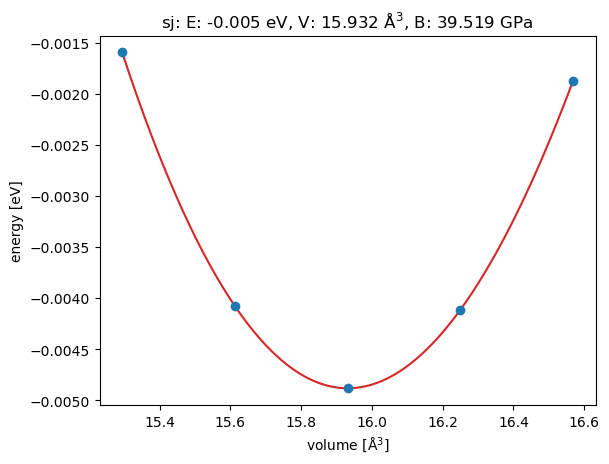

In [13]:
el = "Al"
structure_dict = get_equilibirum_lattice.invoke({"chemical_symbol": el})
plot_equation_of_state.invoke({"atom_dict": structure_dict})

In [14]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, openai_api_key=OPENAI_API_KEY)

In [15]:
tools = [get_equilibirum_lattice, plot_equation_of_state]

In [16]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            # "You are very powerful assistant, but don't know current events.",
            "You are very powerful assistant, but don't know current events. For each query vailidate that it contains a chemical element and otherwise cancel.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

In [17]:
llm_with_tools = llm.bind_tools(tools)

In [18]:
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

In [19]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)



> Entering new AgentExecutor chain...

Invoking: `get_equilibirum_lattice` with `{'chemical_symbol': 'Au'}`


       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 15:48:44        0.002606*       0.3089
LBFGS:    1 15:48:44        0.000032*       0.0778
LBFGS:    2 15:48:44       -0.000135*       0.0031
LBFGS:    3 15:48:44       -0.000135*       0.0000
LBFGS:    4 15:48:44       -0.000135*       0.0000
numbers=[79] positions=[[0.0, 0.0, 0.0]] cell=[[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203], [2.0280828097056185, 2.0280828097056185, 3.6556292469835954e-18]] pbc=[True, True, True]
Invoking: `plot_equation_of_state` with `{'atom_dict': {'numbers': [79], 'positions': [[0.0, 0.0, 0.0]], 'cell': [[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203], [2.0280828097056185, 2.0

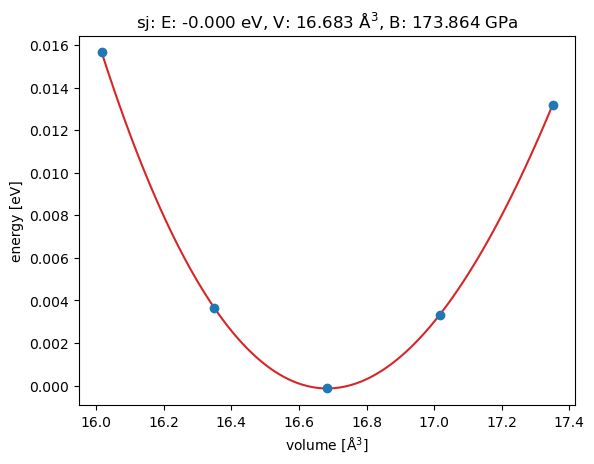

In [20]:
lst = list(agent_executor.stream({"input": "Plot the equation of state of gold"}))  # Yeah this worked !!

In [21]:
lst[0]

{'actions': [ToolAgentAction(tool='get_equilibirum_lattice', tool_input={'chemical_symbol': 'Au'}, log="\nInvoking: `get_equilibirum_lattice` with `{'chemical_symbol': 'Au'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ZIao0afrEOQeIudcsdzzRfnG', 'function': {'arguments': '{"chemical_symbol":"Au"}', 'name': 'get_equilibirum_lattice'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-dff3b71d-df35-49dc-987a-e81fbbf53b59', tool_calls=[{'name': 'get_equilibirum_lattice', 'args': {'chemical_symbol': 'Au'}, 'id': 'call_ZIao0afrEOQeIudcsdzzRfnG'}], tool_call_chunks=[{'name': 'get_equilibirum_lattice', 'args': '{"chemical_symbol":"Au"}', 'id': 'call_ZIao0afrEOQeIudcsdzzRfnG', 'index': 0}])], tool_call_id='call_ZIao0afrEOQeIudcsdzzRfnG')],
 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ZIao0afrEOQeIudcsdzzRfnG', 'function': {'arguments': '{"chemica

In [22]:
lst[1]

{'steps': [AgentStep(action=ToolAgentAction(tool='get_equilibirum_lattice', tool_input={'chemical_symbol': 'Au'}, log="\nInvoking: `get_equilibirum_lattice` with `{'chemical_symbol': 'Au'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ZIao0afrEOQeIudcsdzzRfnG', 'function': {'arguments': '{"chemical_symbol":"Au"}', 'name': 'get_equilibirum_lattice'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-dff3b71d-df35-49dc-987a-e81fbbf53b59', tool_calls=[{'name': 'get_equilibirum_lattice', 'args': {'chemical_symbol': 'Au'}, 'id': 'call_ZIao0afrEOQeIudcsdzzRfnG'}], tool_call_chunks=[{'name': 'get_equilibirum_lattice', 'args': '{"chemical_symbol":"Au"}', 'id': 'call_ZIao0afrEOQeIudcsdzzRfnG', 'index': 0}])], tool_call_id='call_ZIao0afrEOQeIudcsdzzRfnG'), observation=AtomsDict(numbers=[79], positions=[[0.0, 0.0, 0.0]], cell=[[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097

In [23]:
lst[2]

{'actions': [ToolAgentAction(tool='plot_equation_of_state', tool_input={'atom_dict': {'numbers': [79], 'positions': [[0.0, 0.0, 0.0]], 'cell': [[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203], [2.0280828097056185, 2.0280828097056185, 3.6556292469835954e-18]], 'pbc': [True, True, True]}}, log="\nInvoking: `plot_equation_of_state` with `{'atom_dict': {'numbers': [79], 'positions': [[0.0, 0.0, 0.0]], 'cell': [[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203], [2.0280828097056185, 2.0280828097056185, 3.6556292469835954e-18]], 'pbc': [True, True, True]}}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_kh0Nba7scSPNXZGNnS53vVV2', 'function': {'arguments': '{"atom_dict":{"numbers":[79],"positions":[[0.0,0.0,0.0]],"cell":[[4.713281061846748e-17,2.0280828097056185,2.0280828097056

In [24]:
lst[3]

{'steps': [AgentStep(action=ToolAgentAction(tool='plot_equation_of_state', tool_input={'atom_dict': {'numbers': [79], 'positions': [[0.0, 0.0, 0.0]], 'cell': [[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203], [2.0280828097056185, 2.0280828097056185, 3.6556292469835954e-18]], 'pbc': [True, True, True]}}, log="\nInvoking: `plot_equation_of_state` with `{'atom_dict': {'numbers': [79], 'positions': [[0.0, 0.0, 0.0]], 'cell': [[4.713281061846748e-17, 2.0280828097056185, 2.0280828097056203], [2.0280828097056185, 9.364821446984258e-17, 2.0280828097056203], [2.0280828097056185, 2.0280828097056185, 3.6556292469835954e-18]], 'pbc': [True, True, True]}}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_kh0Nba7scSPNXZGNnS53vVV2', 'function': {'arguments': '{"atom_dict":{"numbers":[79],"positions":[[0.0,0.0,0.0]],"cell":[[4.713281061846748e-17,2.0280828097056185,

In [25]:
lst[4]

{'output': 'Here is the plot of the equation of state of gold.',
 'messages': [AIMessage(content='Here is the plot of the equation of state of gold.')]}

# Lessons learned: 
* Handling types between python functions is still ugly, it is not possible to transfer ASE atoms objects. Rather we use pydantic classes, still even for those tuples are not allowed. 